### Analysis of PAR results - Morphological Informality

In [156]:
!pip install mapboxgl
!pip install cartopy
!pip install contextily
!pip install rasterio
!pip install cartopy

In [196]:
# Import Modules

import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import contextily as ctx
import rasterio
from rasterio.plot import show
import mapboxgl
from mapboxgl.utils import create_color_stops
from mapboxgl.viz import ChoroplethViz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import MapboxTiles
from cartopy.io.img_tiles import OSM
import json

In [197]:
# Read files

par = gpd.read_file('/content/validation_data_filtered.gpkg')
grid_nairobi = gpd.read_file('/content/100mGrid_Nairobi.gpkg')
grid_lagos = gpd.read_file('/content/100mGrid_Lagos.gpkg')
grid_kano = gpd.read_file('/content/100mGrid_Kano.gpkg')

In [198]:
# Set Config

par_key = {0: "Low", 1: "Medium", 2: "High"}
par['created_at'] = pd.to_datetime(par['created_at'])

In [199]:
# Describe the shape of the validation data

print("Shape of PAR Data", par.shape)
par['output_model_subdomain_name'].value_counts()

Shape of PAR Data (1879, 16)


,count
output_model_subdomain_name,
Barriers to Healthcare Access,1112
Morphological Informality,767


In [204]:
# Filter Data by Subdomain

subdomain_df = par[par['output_model_subdomain_name'] == 'Morphological Informality'] # Enter the subdomain name
print(subdomain_df['output_model_city_name'].value_counts())

output_model_city_name
Nairobi    492
Lagos      244
Kano        31
Name: count, dtype: int64


In [205]:
# Create city subsets of subdomain_df

kano = subdomain_df[subdomain_df['output_model_city_name'] == 'Kano']
lagos = subdomain_df[subdomain_df['output_model_city_name'] == 'Lagos']
nairobi = subdomain_df[subdomain_df['output_model_city_name'] == 'Nairobi']

print(kano.shape, lagos.shape, nairobi.shape)

(31, 16) (244, 16) (492, 16)


In [210]:
# Filter Data by City

city = lagos # Change this value to select a different city

# Filter city to include only values between two dates

city.head()

,id,created_at,validation,user_id,user_background,user_map_usage,user_location,output_id,output_model,output_model_city_name,output_model_city_country,output_model_subdomain_name,output_result,output_latitude,output_longitude,geometry
224,34fd5529-11da-443a-a403-b50666a0ce08,2024-10-30 12:03:14.360611+00:00,1,cae7c367-4263-45a0-8b21-a41f964015e3,['Community Member'],4.0,"{'lat': '6.5284168', 'lon': '3.2387862', 'disp...",a246cbc4-66bc-495a-ba19-985d0976a591,4f0f9414-1aa8-410a-86e4-618ac311b978,Lagos,Nigeria,Morphological Informality,0,6.526911,3.236277,POINT (3.23628 6.52691)
237,167f8a1a-aaf8-45e4-9c62-3941d4a5d87d,2024-10-30 12:03:47.022579+00:00,1,cae7c367-4263-45a0-8b21-a41f964015e3,['Community Member'],4.0,"{'lat': '6.5284168', 'lon': '3.2387862', 'disp...",f2d60347-e617-4423-9e7b-3d836a559df0,4f0f9414-1aa8-410a-86e4-618ac311b978,Lagos,Nigeria,Morphological Informality,1,6.526911,3.235275,POINT (3.23528 6.52691)
238,92285410-87c4-4f5f-a223-70c9a986a51f,2024-10-30 11:47:02.862879+00:00,0,a3647fb1-29aa-455e-a92f-c4b0566814c3,None,NaN,None,c75a975f-ec33-4210-a0ba-c1674fc0b5d1,4f0f9414-1aa8-410a-86e4-618ac311b978,Lagos,Nigeria,Morphological Informality,0,6.606370,3.429960,POINT (3.42996 6.60637)
239,f3c40fa8-1502-4a47-9610-db22a145f72d,2024-10-30 12:03:19.867523+00:00,1,cae7c367-4263-45a0-8b21-a41f964015e3,['Community Member'],4.0,"{'lat': '6.5284168', 'lon': '3.2387862', 'disp...",9cb08aaa-9548-4f17-8513-c7c77a8de413,4f0f9414-1aa8-410a-86e4-618ac311b978,Lagos,Nigeria,Morphological Informality,0,6.526100,3.235272,POINT (3.23527 6.5261)
240,376200ce-886d-48f9-9737-b29820072d78,2024-10-30 12:04:30.044314+00:00,1,cae7c367-4263-45a0-8b21-a41f964015e3,['Community Member'],4.0,"{'lat': '6.5284168', 'lon': '3.2387862', 'disp...",253a0e79-eb8a-4bd9-ab01-257019046a24,4f0f9414-1aa8-410a-86e4-618ac311b978,Lagos,Nigeria,Morphological Informality,0,6.525289,3.230260,POINT (3.23026 6.52529)


In [212]:
# Select validations by date

PAR_df = city[(city['created_at'] >= '2024-06-28') & (city['created_at'] <= '2024-11-30')] # Enter start date to end date for filtering data - format: '2024-10-24'

PAR_df.shape # Check shape of PAR_df

(244, 16)

In [213]:
# Count of validations given as low, medium or high MI by PAR participants vs. model outputs

count_validations = PAR_df['validation'].value_counts()
count_outputs = PAR_df['output_result'].value_counts()
print('Key = [0: Low; 1: Medium; 2: High]\nValidations\n', count_validations)
print('\nModel Outputs\n', count_outputs)

Key = [0: Low; 1: Medium; 2: High]
Validations
 validation
1    139
0     60
2     45
Name: count, dtype: int64

Model Outputs
 output_result
0    109
1    103
2     32
Name: count, dtype: int64


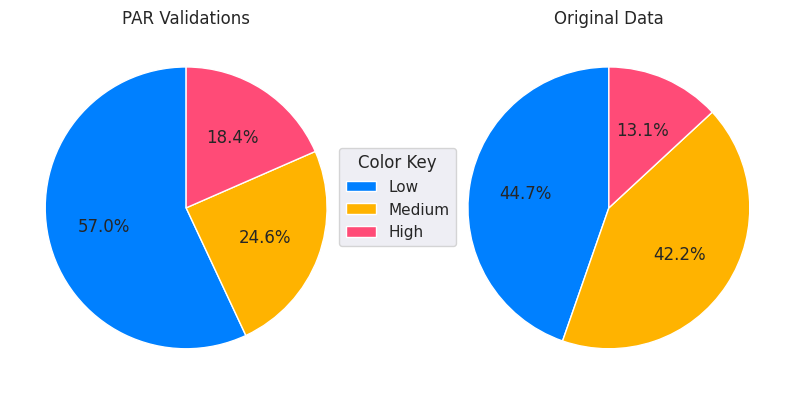

In [214]:
# Create Pie Charts summarising PAR Data

colors = sns.color_palette([ '#0080FF', '#FFB300', '#FF4B77'])
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(count_validations.to_dict().values(), autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].set_title(f'PAR Validations')
axs[1].pie(count_outputs.to_dict().values(), autopct='%1.1f%%', startangle=90, colors=colors)
axs[1].set_title(f'Original Data')
fig.legend(list(par_key.values()), title="Color Key", loc="center", ncols=1)
plt.show()

In [215]:
# Create alluvial plot to show change in distribution between model output x PAR validation

# Group by the two columns and count the occurrences
data = PAR_df.groupby(['output_result', 'validation']).size().reset_index(name='Count')

levels = list(par_key.keys())
level_labels = list(par_key.values())

# Create source and target for the Sankey diagram
source = data['output_result'].apply(lambda x: levels.index(x)).tolist()
target = data['validation'].apply(lambda x: levels.index(x) + len(levels)).tolist()
counts = data['Count'].tolist()

# Generate colors for the nodes
color_list = [ '#0080FF', '#FFB300', '#FF4B77']

# Ensure same color for corresponding categories in Category1 and Category2
node_colors = color_list[:len(levels)] + color_list[:len(levels)]
link_colors = [node_colors[src] for src in source]

# Create the alluvial plot using plotly
fig = go.Figure(go.Sankey(
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=2 * level_labels,
        color=node_colors  # Apply node colors
    ),
    link=dict(
        source=source,
        target=target,
        value=counts,
        color=link_colors  # Ensure the links have matching colors
    )
))

# Update layout to reduce the width of the plot
fig.update_layout(
    title_text="Redistribution of Dataset According to PAR Validations",
    font_size=14,
    height=600,
)

fig.show()

In [229]:
# Create a Geo Dataframe by joining the PAR_df to the Chosen City Grid

selected_grid = grid_lagos # Change this to match the city you've chosen - Eg. city = kano -> selected_grid = grid_kano

PAR_gdf = gpd.sjoin(selected_grid.to_crs(4326), PAR_df, how="left", predicate='contains')
PAR_gdf = PAR_gdf.dropna(subset=['validation']).reset_index(drop=True)
print(PAR_gdf.shape)

(244, 24)


In [230]:
# Map the Validation Data vs Original Data

# Set Access Token
px.set_mapbox_access_token('pk.eyJ1IjoiYW5keWNsYXJrZSIsImEiOiJjbDFvd2Y2eXcwM2ljM2NxdTU3Z2lpNmhhIn0.z5Et74WK71oansNVN5oDYQ')

# Cast output_result & validation to string
PAR_gdf['output_result'] = PAR_gdf['output_result'].astype(str)
PAR_gdf['validation'] = PAR_gdf['validation'].astype(str)


center_lat = PAR_gdf.output_latitude.mean()
center_lon = PAR_gdf.output_longitude.mean()

fig = px.choropleth_mapbox(PAR_gdf,
                           geojson=PAR_gdf.geometry,
                           locations=PAR_gdf.index,
                           color='validation',  # Color by validation column
                           color_discrete_sequence=['#0080FF', '#FFB300', '#FF4B77'],
                          #  color_discrete_map={'0': '#0080FF', '1': '#FFB300', 2: '#FF4B77'},
                          #  color_continuous_scale=['#0080FF', '#FFB300', '#FF4B77'],  # Choose your color scale
                           mapbox_style="open-street-map",
                           zoom=10,
                           center={"lat": center_lat, "lon": center_lon}, # Pass the calculated mean values
                           opacity=0.5,
                           hover_data=['created_at'])  # Add other columns to hover

fig.update_layout(
    title="PAR Validations 👇",
    width=2500, # Set the desired width in pixels
    height=1080, # Set the desired height in pixels
    margin={"r": 0, "t": 50, "l": 0, "b": 50}  # Adjust margin if needed
)
fig.show()

fig2 = px.choropleth_mapbox(PAR_gdf.drop_duplicates(subset=['output_id']),
                           geojson=PAR_gdf.drop_duplicates(subset=['output_id']).geometry,
                           locations=PAR_gdf.drop_duplicates(subset=['output_id']).index,
                           color='output_result',  # Color by validation column

                           color_discrete_sequence=['#0080FF', '#FFB300', '#FF4B77'],  # Choose your color scale
                           mapbox_style="open-street-map",
                           zoom=10,
                           center={"lat": center_lat, "lon": center_lon}, # Pass the calculated mean values
                           opacity=0.5,
                           hover_data=['created_at'])  # Add other columns to hover

fig2.update_layout(
    title="Original Data 👇",
    width=2500, # Set the desired width in pixels
    height=1080, # Set the desired height in pixels
    margin={"r": 0, "t": 25, "l": 0, "b": 0},  # Adjust margin if needed
)
fig2.show()